# Simple classification model using Kolmogorov-Arnold Network
This is a simple notebook to demonstrate basic principles of Kolmogorov-Arnold Network model design and traning with highly imbalanced training data. 

(c) Mikko Kursula 2024. MIT License. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
import torch.nn as nn
import time

## Create data and visualize it

In [2]:
def define_dataset(n_samples):
    """
    Get random numbers in the [-1, 1] and label those so that the labels 
    are arranged in random circles that do not touch each other. 
    """
    max_circle = 20 
    final_x = np.random.rand(n_samples, 2) * 2 - 1    
    final_labels = np.zeros(n_samples)

    np.random.seed(123)
    temp_x = np.random.rand(20000, 2) * 2 - 1
    temp_labels = np.zeros(20000)

    n_circle = 0 
    while n_circle < max_circle:
        loc_x = np.random.rand() * 2 - 1
        loc_y = np.random.rand() * 2 - 1
        radius = np.random.rand() * 0.2 + 0.1
        thickness = np.random.rand() * 0.01 + 0.03
        dist = np.sqrt((temp_x[:, 0] - loc_x)**2 + (temp_x[:, 1] - loc_y)**2)
        mask = (dist >= radius - thickness) & (dist <= radius + thickness)
        if np.sum(temp_labels[mask]) > 0: 
            continue
        temp_labels[mask] = 1

        thickness -= 0.01
        dist = np.sqrt((final_x[:, 0] - loc_x)**2 + (final_x[:, 1] - loc_y)**2)
        mask = (dist >= radius - thickness) & (dist <= radius + thickness)
        final_labels[mask] = 1
        n_circle += 1
  
    final_labels = final_labels.reshape(-1, 1)
    return final_x.astype(np.float32), final_labels.astype(np.float32)


def scatter_plot(input_data, labels, figsize=(10, 8), cmap=None, vmin=0, vmax=1):
    """
    Plot all the points and color those according to the classifications. 
    """
    if cmap is None: 
        colors = [(0, 0, 1), (0, 0.8, 0.8), (1, 1, 0), (1, 0, 0)]  # Blue, Cyan, Yellow, Red
        cmap = LinearSegmentedColormap.from_list("blue_cyan_red", colors)
    
    plt.figure(figsize=figsize)
    plt.axes().set_aspect('equal')
    ax = plt.gca()
    ax.set_facecolor((0, 0, 0))
    plt.scatter(input_data[:, 0], input_data[:, 1], c=labels, alpha=1, s=10, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

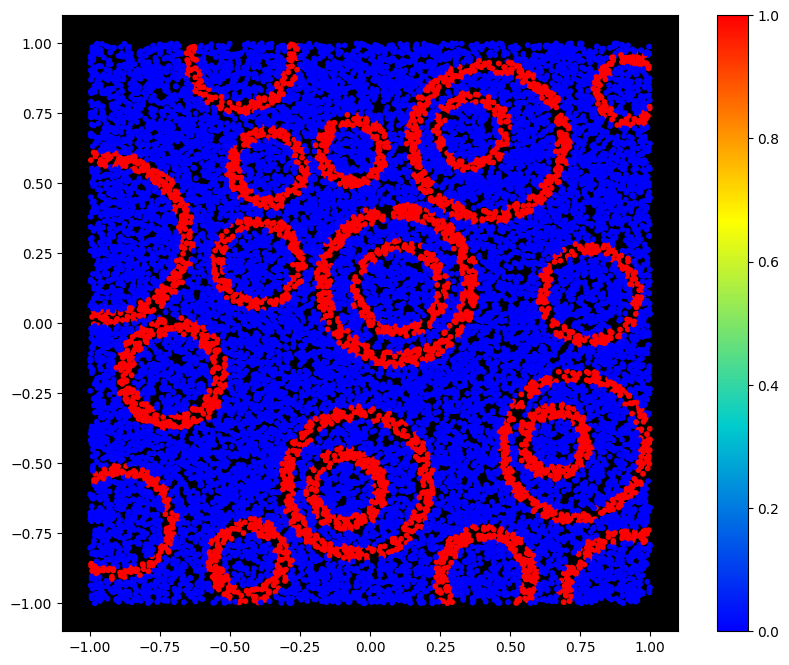

In [3]:
input_data, target_data = define_dataset(n_samples=20000)
scatter_plot(input_data, target_data)

## Check class balance

In [4]:
n_neg = np.sum(target_data == 0)
n_pos = np.sum(target_data == 1)
print('Class 0 samples : {}'.format(n_neg))
print('Class 1 samples : {}'.format(n_pos))
print('Zero/one class ratio : {:.2f}'.format(n_neg / n_pos))

Class 0 samples : 15305
Class 1 samples : 4695
Zero/one class ratio : 3.26


# KAN model

In [5]:
class VectorizedKANLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_knots, x_min, x_max):
        """
        Vectorized Kolmogorov-Arnold Network Layer with B-splines per connection.
        Supports both linear and quadratic B-splines.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of neurons in the hidden layer.
            num_knots (int): Number of knots for each spline.
            x_min (float): Minimum x-value for the splines.
            x_max (float): Maximum x-value for the splines.
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        if num_knots < 3:
            raise ValueError("Number of knots must be at least 3 for quadratic B-splines.")

        self.num_knots = num_knots
        self.x_min = x_min
        self.x_max = x_max

        # Initialize control points for all splines: Shape (hidden_dim, input_dim, num_knots)
        self.y = nn.Parameter(torch.randn(hidden_dim, input_dim, num_knots) * 0.1)

        # Fixed knot positions shared across all splines
        self.register_buffer('knots', torch.linspace(x_min, x_max, steps=num_knots))
        
        # Bias term for each hidden neuron
        self.bias = nn.Parameter(torch.rand(hidden_dim) * 0.1)

    def forward(self, x):
        """
        Forward pass for the vectorized KAN layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tensor: Output tensor of shape (batch_size, hidden_dim).
        """
        batch_size, _ = x.size()

        # Clamp input to the spline range
        x_clamped = torch.clamp(x, self.x_min, self.x_max)  # (batch_size, input_dim)

        # Knot spacing
        h = (self.x_max - self.x_min) / (self.num_knots - 1)

        # Quadratic B-splines
        # Compute knot indices
        u = (x_clamped - self.x_min) / h  # Scaled input
        k = torch.floor(u).long()
        k = k.clamp(1, self.num_knots - 2)

        # Local parameter t in [0, 1)
        t = u - k

        # Basis functions
        B0 = 0.5 * (1 - t) ** 2
        B1 = -t ** 2 + t + 0.5
        B2 = 0.5 * t ** 2
        B = torch.stack([B0, B1, B2], dim=-1)  # (batch_size, input_dim, 3)

        # Indices for control points
        k_indices = torch.stack([k - 1, k, k + 1], dim=-1)
        k_indices = k_indices.clamp(0, self.num_knots - 1)

        # Expand dimensions for batch processing
        B = B.unsqueeze(1)  # (batch_size, 1, input_dim, 3)
        k_indices = k_indices.unsqueeze(1).expand(-1, self.hidden_dim, -1, -1)

        # Expand control points
        y_expanded = self.y.unsqueeze(0).expand(batch_size, -1, -1, -1)

        # Gather control points
        y_gathered = torch.gather(y_expanded, 3, k_indices)

        # Compute spline outputs
        spline_outputs = (B * y_gathered).sum(dim=3)  # (batch_size, hidden_dim, input_dim)

        # Sum over input dimensions
        hidden = spline_outputs.sum(dim=2)  # (batch_size, hidden_dim)

        # Add bias term
        output = hidden + self.bias
        return output


class KANModel(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 output_dim: int,
                 hidden_layers: list, 
                 num_knots: int = 6,
                 x_min: float = -1, 
                 x_max: float = 1,
                ):
        """
        Multilayer Kolmogorov-Arnold Network (KAN) model with quadratic B-splines per connection.

        Args:
            input_dim (int): Number of input features.
            output_dim (int): Dimension of the output.
            hidden_layers (list of int): Number of neurons in each hidden KAN layer.
            num_knots (int): Number of knots for each spline. Must be >=3 for quadratic B-splines.
            x_min: minimum input value in spline calculation.
            x_max: maximum input value in spline calculation.
        """
        super().__init__()
        self.layers = nn.ModuleList()

        # Model layers
        current_input_dim = input_dim
        for layer_dim in hidden_layers + [output_dim]:
            self.layers.append(VectorizedKANLayer(
                input_dim=current_input_dim, 
                hidden_dim=layer_dim, 
                num_knots=num_knots,
                x_min=x_min,
                x_max=x_max,
            ))
            current_input_dim = layer_dim  # Update input_dim for the next layer
    
    def forward(self, x):
        """
        Forward pass for the Vectorized KAN model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tensor: Output tensor of shape (batch_size, output_dim).
        """
        for layer in self.layers:
            x = layer(x)  
        return x

## Setup and train the model

In [6]:
# Hyperparameters
input_dim = 2
output_dim = 1
hidden_layers = [15, 10]
num_knots = 8
learning_rate = 0.001
num_epochs = 70      
batch_size = 32

# Setup datasets
dataset = torch.utils.data.TensorDataset(torch.from_numpy(input_data), torch.from_numpy(target_data))
split_ratio = 0.8
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [split_ratio, 1 - split_ratio])

# Create separate DataLoaders for train and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Setup model 
model = KANModel(
    input_dim=input_dim, 
    output_dim=output_dim,
    hidden_layers=hidden_layers,
    num_knots=num_knots,
)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_loss = []
test_loss = []
t0 = time.time()
for epoch in range(1, num_epochs + 1):
    # Train 
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_func(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_train_loss += loss.item() * batch_X.size(0)
    epoch_train_loss /= len(train_loader.dataset)
    train_loss.append(epoch_train_loss)

    # Test
    model.eval()
    epoch_test_loss = 0.0
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = loss_func(outputs, batch_y)
        epoch_test_loss += loss.item() * batch_X.size(0)
    epoch_test_loss /= len(test_loader.dataset)
    test_loss.append(epoch_test_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs}, train: {epoch_train_loss:.6f}, test: {epoch_test_loss:.6f}")

td = time.time() - t0
print(f"Training time: {td:.2f} s")

Epoch 5/70, train: 0.136400, test: 0.134975
Epoch 10/70, train: 0.111894, test: 0.122631
Epoch 15/70, train: 0.096790, test: 0.104650
Epoch 20/70, train: 0.088604, test: 0.090355
Epoch 25/70, train: 0.082883, test: 0.086603
Epoch 30/70, train: 0.078865, test: 0.087137
Epoch 35/70, train: 0.075990, test: 0.081881
Epoch 40/70, train: 0.073561, test: 0.082694
Epoch 45/70, train: 0.072229, test: 0.073418
Epoch 50/70, train: 0.069926, test: 0.080233
Epoch 55/70, train: 0.067641, test: 0.076552
Epoch 60/70, train: 0.066273, test: 0.073163
Epoch 65/70, train: 0.066056, test: 0.070547
Epoch 70/70, train: 0.063868, test: 0.071736
Training time: 32.11 s


## Plot training results

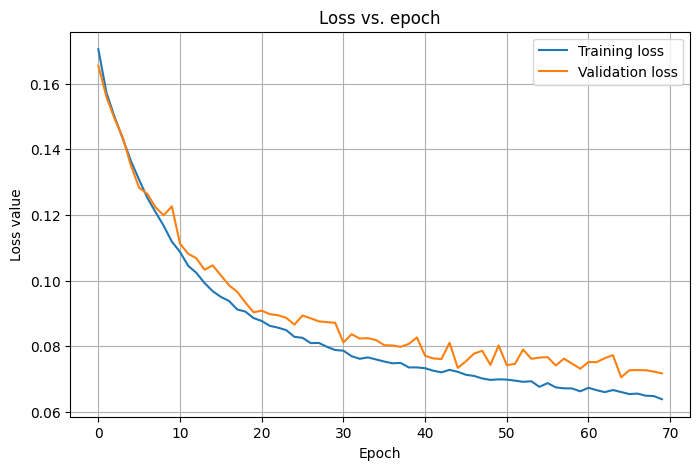

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.title('Loss vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

## Testing
This demonstrates simple classification quality evaluation and the typical pitfalls in using common metrics such as accuracy.

In [8]:
# Make predictions using new data 
x, y_true = define_dataset(n_samples=100000)
x = torch.from_numpy(x)
y_pred = model(x).detach().numpy()

In [9]:
# Categorize y values to True and False categories. 
class_threshold = 0.5

# Define true labels in boolean values
true = np.zeros(y_true.shape)
mask = y_true >= class_threshold
true[mask] = True
true[~mask] = False

# Predicted boolean values
pred = np.zeros(y_pred.shape)
mask = y_pred >= class_threshold
pred[mask] = True
pred[~mask] = False

# Define true and false positive and negative counts 
TP = np.sum((true == True) & (pred == True))
TN = np.sum((true == False) & (pred == False))
FP = np.sum((true == False) & (pred == True))
FN = np.sum((true == True) & (pred == False))

# Scores
precision = TP / (TP + FP) if ((TP + FP) != 0) else 0
recall = TP / (TP + FN) if ((TP + FN) != 0) else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1_score = 2 * (precision * recall) / (precision + recall) if ((precision + recall) != 0) else 0

print(f'Precision: {precision:.3f}')
print(f'Recall   : {recall:.3f}')
print(f'Accuracy : {accuracy:.3f}')
print(f'F1 score : {f1_score:.3f}')

Precision: 0.830
Recall   : 0.807
Accuracy : 0.916
F1 score : 0.818


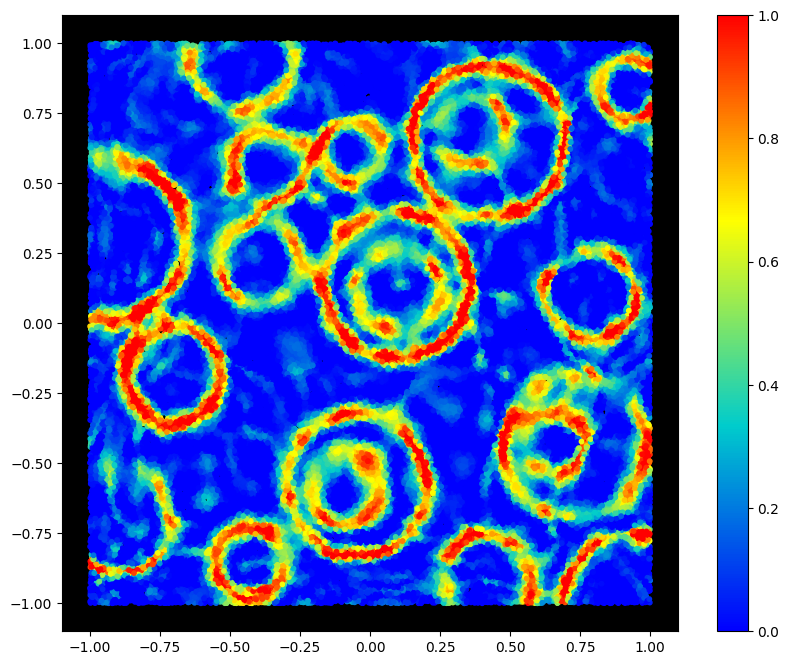

In [10]:
# Plot the prediction results using continuous predicted values. 
# This illustrates the decision boundaries and possible areas of model confusion. 

scatter_plot(x, y_pred)

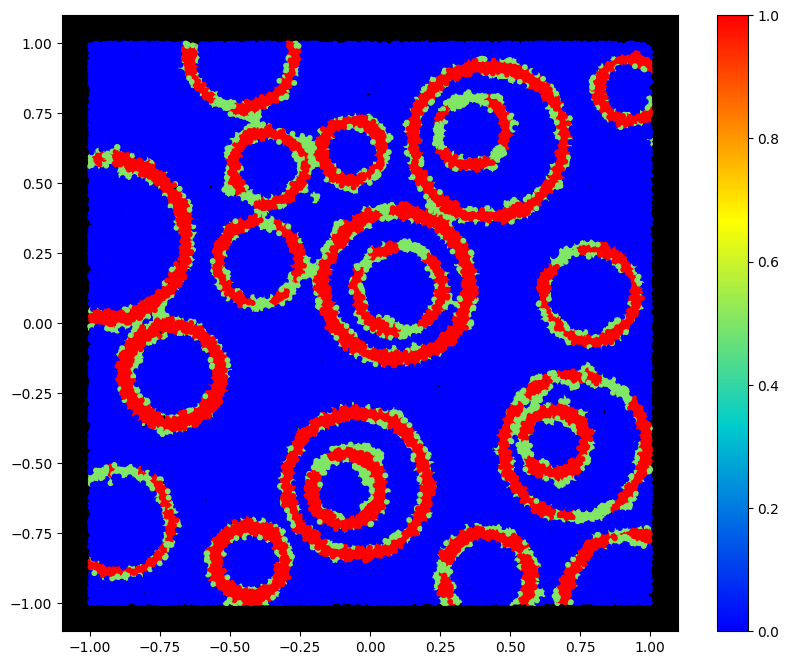

In [11]:
# Same plot as above, but this time with categorized predictions
# Incorrectly categorized samples are shown with value 0.5 (green)
c_val = pred.copy()
mask = pred != true
c_val[mask] = 0.5

scatter_plot(x, c_val)

## Spline visualization 

In [12]:
def visualize_spline_connection(model, layer_index, input_index, output_index):
    """
    Visualizes a specific spline connection in a Kolmogorov-Arnold Network (KAN) model
    using the layer's forward method.

    Args:
        model (KANModel): The KAN model instance.
        layer_index (int): Index of the layer containing the input neuron.
        input_index (int): Index of the input neuron in the specified layer.
        output_index (int): Index of the output neuron in the next layer.

    Raises:
        IndexError: If the specified layer, input, or output indices are out of range.
    """
    import copy
    
    # Validate layer index
    if layer_index < 0 or layer_index >= len(model.layers):
        raise IndexError(f"Layer index {layer_index} is out of range. Model has {len(model.layers)} layers.")
    
    layer = model.layers[layer_index]
    
    # Validate input and output indices
    if input_index < 0 or input_index >= layer.input_dim:
        raise IndexError(f"Input index {input_index} is out of range for layer {layer_index} with input_dim {layer.input_dim}.")
    if output_index < 0 or output_index >= layer.hidden_dim:
        raise IndexError(f"Output index {output_index} is out of range for layer {layer_index} with hidden_dim {layer.hidden_dim}.")
    
    # Extract layer parameters
    x_min = layer.x_min
    x_max = layer.x_max
    num_points = 1000  # Number of points for smooth plotting

    # Generate a range of input values for the specified input neuron
    x_values = np.linspace(x_min, x_max, num_points)
    
    # Create input tensor:
    # Initialize all inputs to zero
    # Set the specified input_index to vary across x_values
    input_tensor = torch.zeros(num_points, layer.input_dim)
    input_tensor[:, input_index] = torch.tensor(x_values)
    
    # Ensure the input tensor is on the same device as the model
    input_tensor = input_tensor.to(next(layer.parameters()).device)
    
    # Create a copy of the layer with zeroed control points for other inputs
    layer_copy = copy.deepcopy(layer)
    with torch.no_grad():
        # Zero control points for all input dimensions except the specified one
        mask = torch.ones_like(layer_copy.y)
        mask[:, input_index, :] = 0  # Set mask to zero for the specified input index
        layer_copy.y.data = layer_copy.y.data * (1 - mask)
    
    # Perform forward pass using the copied layer
    with torch.no_grad():
        layer_output = layer_copy(input_tensor)  # Shape: (num_points, hidden_dim)
    
    # Extract the output for the specified output neuron
    output_values = layer_output[:, output_index].cpu().numpy()
    
    # Extract the bias for the output neuron
    bias = layer_copy.bias[output_index].item()
    
    # Subtract the bias
    spline_output = output_values - bias
    
    # Plot the spline
    plt.figure(figsize=(6, 4))
    plt.plot(x_values, spline_output, color='blue', label='Spline Output')
    
    # Extract control points for the specified connection
    y_j_i = layer_copy.y[output_index, input_index, :].detach().cpu().numpy()  # Shape: (num_knots,)
    knots = layer_copy.knots.detach().cpu().numpy()  # Shape: (num_knots,)
    plt.scatter(knots, y_j_i, color='red', zorder=5, label='Control Points')
    
    title = 'Spline Connection and Control Point Visualization'
    title += f'\nLayer {layer_index}: Node {input_index} → Layer {layer_index + 1}: Node {output_index}'
    plt.title(title)
    plt.xlabel('Input x')
    plt.ylabel('Spline Output y(x) - Bias')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


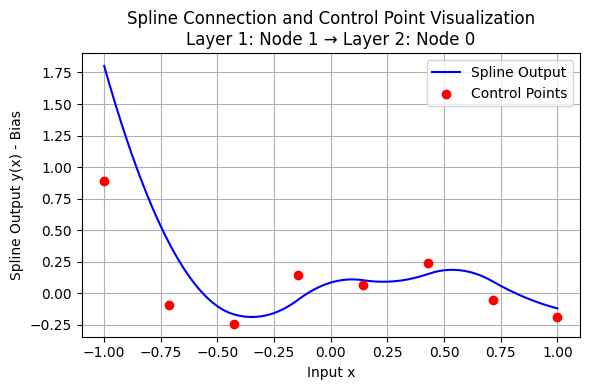

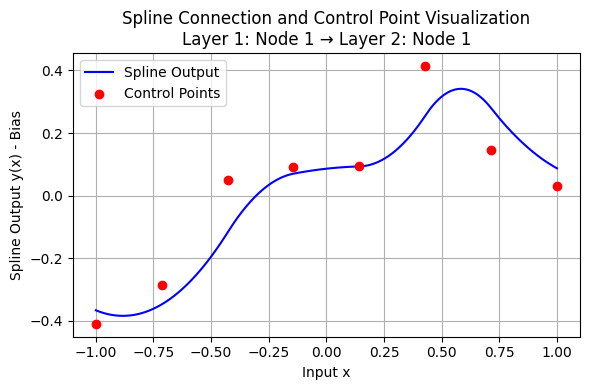

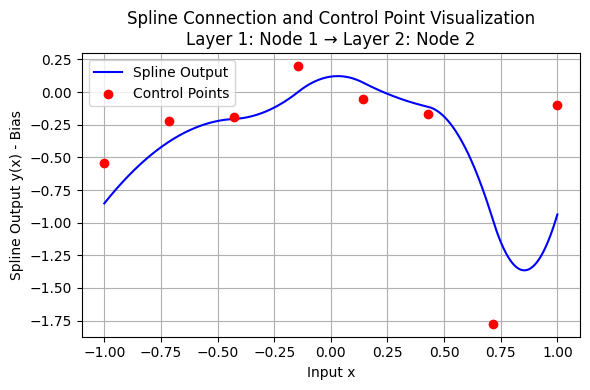

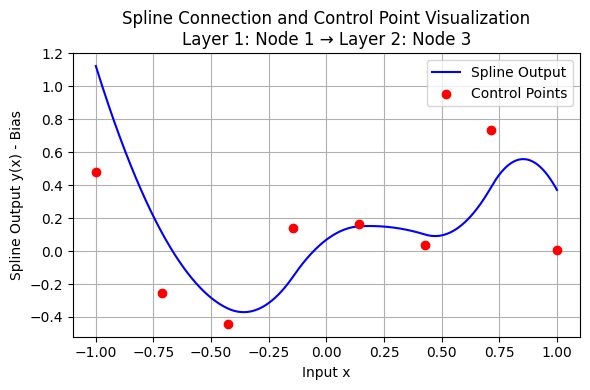

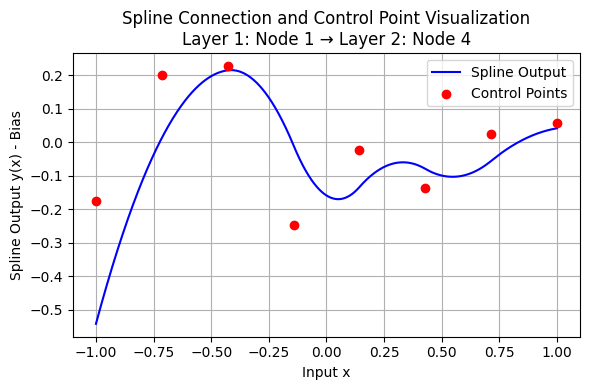

In [13]:
selected_layer = 1
node_a = 1
for i in range(5):
    node_b = i
    visualize_spline_connection(model, selected_layer, node_a, node_b)